This notebook is used to get an insight into what voxelization size is adequate for the data. This is done by finding the nearest neighbour for each point in a pointcloud and investigating the resulting distribution

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import master_bar, progress_bar
from scipy.spatial import cKDTree
from scipy import stats

# Get access to all the files in the repository
cwd = os.getcwd()
parentDir = os.path.dirname( cwd )
sys.path.append(parentDir)

In the following code the usual distance between a point and its nearest neighbour is investigated. For this for each point cloud a distribution of distance is generated. This distribution is then binned and its mode is determined. Then for all clouds the modes are saved and the distribution of modes is generated.

In [ ]:
def calculate_nearest_neighbor_distances(cloud):
    """
    Calculate the distances to the nearest neighbor for each point in the cloud.
    
    Args:
        cloud: A numpy array of shape (N, 3) representing the point cloud.
    
    Returns:
        distances: A numpy array containing the distances to the nearest neighbor for each point.
    """
    # Create a k-d tree for fast nearest neighbor search
    tree = cKDTree(cloud)
    
    # Query the tree to get the nearest neighbor distance for each point (excluding itself)
    distances, _ = tree.query(cloud, k=2)  # k=2 because the nearest neighbor to a point is the point itself
    
    # The first value in distances is the distance to itself, so we take the second value
    return distances[:, 1]  # Return distances to the nearest neighbors


def get_nn_distance_mode_distribution( cloudDir, plotSavePath=None ):
    """
    Create a distribution of modes of the distribution of nearest neighbour distances over the pointclouds in the data.

    Args:
        cloudDir: A path to the directory where the clouds are stored as .npy files
        plotSavePath: A path to the directory were the resulting plot should be stored

    Returns:
        modes: An array of all the modes of the distributions of points in the individual clouds
    """
    # Create a list of paths to all the .txt files of pointclouds
    npy_files = [os.path.join( cloudDir, file ) for file in os.listdir( cloudDir ) if file.endswith(".npy") ]

    modes = []
    # Create binning with width of 1mm
    bins = np.arange(0.0,1.001,0.001)
    print("Calculating modes...")
    for file in progress_bar(npy_files):
        # Load the cloud
        cloud = np.load(file)

        # Get array of distance to nearest neighbour
        distances = calculate_nearest_neighbor_distances(cloud)

        # Bin the distances, find the most occupied bin and calculate its according distance
        binned = np.digitize( distances, bins )
        mode, count = stats.mode( binned, keepdims=True )
        modes.extend((mode*0.001-0.001)*100)

    # Find the mode and average of the distribution of modes
    modeOfModes, count = stats.mode( modes, keepdims=True )
    avgOfModes = np.mean( modes )
    # Plot
    plt.figure()
    plt.hist(modes, bins=50, density=True)
    plt.vlines(modeOfModes[0], ymin=0, ymax=30, linestyle='dashed', color='red', label='mode')
    plt.vlines(avgOfModes, ymin=0, ymax=30, linestyle='dotted', color='green', label='average')
    plt.xlabel("Mode of nearest neighbour distribution [cm]")
    plt.ylabel("PDF")
    plt.title("Distribution of Modes of Nearest Neighbour Distance Distributions")
    plt.grid()
    plt.legend()

    if plotSavePath:
        plt.savefig( os.path.join(plotSavePath, "Mode_distribution.png"), dpi=300 )

    plt.show()
    return modes

Calculating modes...


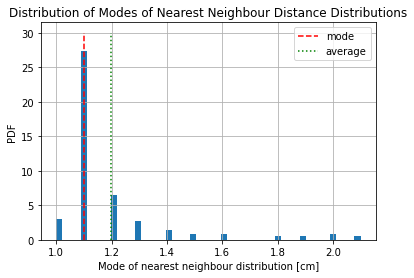

In [24]:
pointCloudDir = os.path.join( parentDir, "data", "raw", "cloud" )

plotSavePath = os.path.join(parentDir,"plots","DataAnalysis")

modes = get_nn_distance_mode_distribution( cloudDir=pointCloudDir, plotSavePath=plotSavePath )